# Preprocess Continuous Data - Resting State
## MS008
10/01/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
subj_id = 'MS008'

# Specify root directory for data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/resting_state_proj/resting_state_ieeg/'
anat_dir = f'{base_dir}anat'
neural_dir = f'{base_dir}preprocess/raw_data/{subj_id}'
save_dir = f'{base_dir}preprocess/clean_data/{subj_id}'
os.makedirs(save_dir,exist_ok = True)

#### Import Data

In [36]:
edf_files = glob(f'{neural_dir}/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)
mne_data

<RawEDF | MS008_Resting_iEEG.edf, 276 x 678016 (662.1 s), ~1.39 GB, data loaded>

In [37]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'C63',
 'C64',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RAglT10',
 'RAglT11',
 'RAglT12',
 'RAglT13',
 'RAglT14',
 'RAglT15',
 'RAglT16',
 'LHplT1',
 'LHplT2',

# Import Anat Recon Info - check all elecs are present in data + recon sheet


In [38]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]
elec_locs = elec_locs.dropna(axis=0, how = 'all')
elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCas1,A13_L,-9.181259,37.595151,0.399772,-7.760768,29.351037,-16.334162,White,Left MFC medial frontal cortex,Area s32,L Rectal Gyrus,L OrG,Left frontal pole 1 B,WM,NaN
1,LaCas10,A9/46d_L,-25.547852,38.395047,40.777025,-27.108802,42.288239,30.742824,Gray,Left MFG middle frontal gyrus,Unknown,L Middle Frontal Gyrus,L MFG,Left middle frontal gyrus 3 A,NaN,NaN
2,LaCas11,A9/46d_L,-27.144592,38.794996,45.574323,-28.906378,44.081606,36.228537,Gray,Left MFG middle frontal gyrus,Unknown,L Middle Frontal Gyrus,L MFG,Left middle frontal gyrus 3 B,NaN,NaN
3,LaCas12,Unknown,-28.741333,38.794996,50.371620,-30.694326,45.530011,41.862931,Unknown,Unknown,Unknown,L Superior Frontal Gyrus,Unknown,Left middle frontal gyrus 3 B,OOB,NaN
4,LaCas2,A13_L,-11.177185,37.195202,4.797294,-10.275087,30.396791,-11.027941,White,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L OrG,Left cingulate gyrus C,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,RPEP2,A39rd_R,31.934814,-48.393759,20.388511,36.891150,-56.539538,35.515119,Gray,Right Cerebral White Matter,Area hIP1 (IPS),R Angular Gyrus,R IPL,Unknown,lesion,NaN
140,RPEP3,A39rd_R,34.329926,-51.993295,22.787160,39.464875,-59.707416,39.502152,Gray,Right AnG angular gyrus,Unknown,R Angular Gyrus,R IPL,Right supramarginal gyrus 5 B,lesion,NaN
141,RPEP4,A39rd_R,37.124222,-55.192882,25.585583,42.519900,-62.351204,43.900651,Gray,Right AnG angular gyrus,Area PGa (IPL),R Angular Gyrus,R IPL,Unknown,lesion,NaN
142,RPEP5,A39rd_R,39.519333,-59.192367,27.984232,45.235396,-65.966077,48.102822,Gray,Right AnG angular gyrus,Area PGp (IPL),R Angular Gyrus,R IPL,Right supramarginal gyrus 5 B,lesion,NaN


### Fix edf channel names

In [39]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [40]:
unmatched_names

[]

In [41]:
unmatched_seeg

[]

In [42]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}
new_name_dict

{'LmOlF1': 'lmoif1',
 'LmOlF2': 'lmoif2',
 'LmOlF3': 'lmoif3',
 'LmOlF4': 'lmoif4',
 'LmOlF5': 'lmoif5',
 'LmOlF6': 'lmoif6',
 'LmOlF7': 'lmoif7',
 'LmOlF8': 'lmoif8',
 'LmOlF9': 'lmoif9',
 'LmOlF10': 'lmoif10',
 'RmOlF1': 'rmoif1',
 'RmOlF2': 'rmoif2',
 'RmOlF3': 'rmoif3',
 'RmOlF4': 'rmoif4',
 'RmOlF5': 'rmoif5',
 'RmOlF6': 'rmoif6',
 'RmOlF7': 'rmoif7',
 'RmOlF8': 'rmoif8',
 'RmOlF9': 'rmoif9',
 'RmOlF10': 'rmoif10',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'racas11',
 'RaCaS12': 'racas12',
 'RaCaS13': 'racas13',
 'RaCaS14': 'racas14',
 'LmCmS1': 'lm

In [43]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS008_Resting_iEEG.edf, 276 x 678016 (662.1 s), ~1.39 GB, data loaded>

In [32]:
unmatched_seeg #make sure there are no unmatched names

[]

In [44]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) 
#print extra channels in mne_data.ch_names and make sure none of them are neural channels


['c63', 'c64', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'res', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', '

In [45]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 58 left & 87 right sEEG electrodes
We have a total of 145 sEEG electrodes


In [46]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names)) # it is either called DC1 or research
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS008_Resting_iEEG.edf, 145 x 678016 (662.1 s), ~750.2 MB, data loaded>

In [47]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS008_Resting_iEEG.edf, 145 x 678016 (662.1 s), ~750.2 MB, data loaded>

In [48]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS008_Resting_iEEG.edf, 145 x 678016 (662.1 s), ~750.3 MB, data loaded>

### Notch filter line noise

In [49]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    2.3s finished


<RawEDF | MS008_Resting_iEEG.edf, 145 x 678016 (662.1 s), ~750.3 MB, data loaded>

### Resampling data 

In [50]:
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    1.9s finished


<RawEDF | MS008_Resting_iEEG.edf, 145 x 331062 (662.1 s), ~366.4 MB, data loaded>

### Bad Channel Removal (manual)

Let's pick out any bad channels missed by automatic screening (visual inspection as a reference), or restore channels that were erroneously deemed bad. You have to press the "power" button twice (once for the plot and once for the panel beneath it) when you're done so that you're manual changes are saved.

<IPython.core.display.Javascript object>


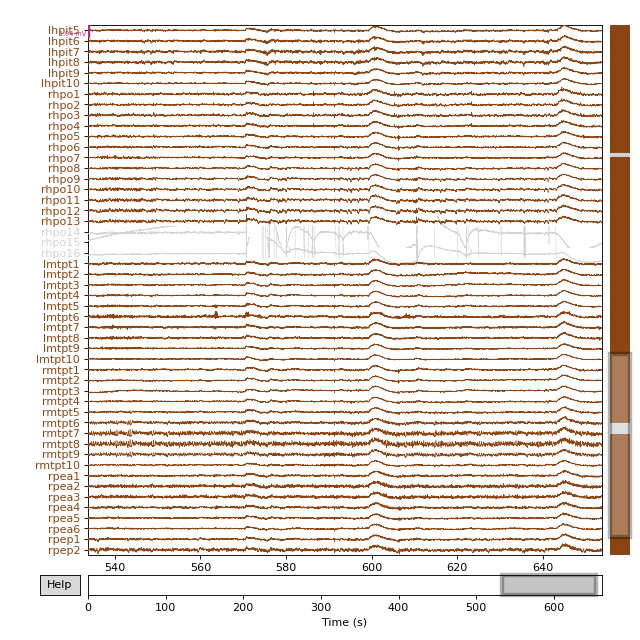

<IPython.core.display.Javascript object>


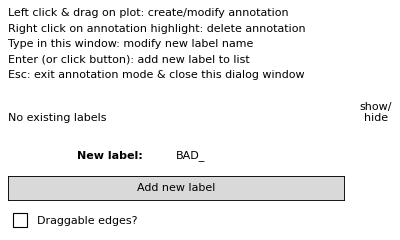

In [51]:
%matplotlib notebook
%matplotlib notebook

fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a') #lots of bad times 

In [52]:
mne_data.info['bads'] #sanity check that bads info saved


['racas4', 'rhpo14', 'rhpo15', 'rhpo16']

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [53]:
#define oob elecs as bad before saving out lfp file 
oob_elec = [elec_locs['label'].iloc[ind].lower() for ind, data in elec_locs['Manual Examination'].str.lower().items() if data=='oob']
oob_elec

['lacas12',
 'lhpit10',
 'lmcms8',
 'lmtpt10',
 'lmtpt3',
 'racas13',
 'racas14',
 'ragit14',
 'ragit15',
 'ragit16',
 'rhpo15',
 'rhpo16',
 'rmcms8',
 'rmoif10',
 'rmtpt10',
 'rmtpt2',
 'rmtpt3',
 'rmtpt9']

In [54]:
bad_ch= mne_data.info['bads']
bad_ch = bad_ch + oob_elec
mne_data.info['bads'] = list(np.unique(bad_ch))
mne_data.info['bads'] # make sure an WM referenced pairs that include these channels is excluded. 

['lacas12',
 'lhpit10',
 'lmcms8',
 'lmtpt10',
 'lmtpt3',
 'racas13',
 'racas14',
 'racas4',
 'ragit14',
 'ragit15',
 'ragit16',
 'rhpo14',
 'rhpo15',
 'rhpo16',
 'rmcms8',
 'rmoif10',
 'rmtpt10',
 'rmtpt2',
 'rmtpt3',
 'rmtpt9']

In [55]:
mne_data.save(f'{save_dir}/{subj_id}_raw_ieeg.fif',overwrite=True)

# Rereference data 

### WM REF

In [56]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site='MSSM')

In [57]:
# not super elegant way to do this, but it works
anode_list_clean = []
removed_anode_index = []
for i,ch in enumerate(anode_list):
    if ch not in bad_ch:
        anode_list_clean.append(ch)
    else:
        removed_anode_index.append(i)

cathode_list_update = [cathode_list[i] for i in range(len(cathode_list)) if i not in removed_anode_index]

cathode_list_clean = []
for ch in cathode_list_update:
    if ch not in bad_ch:
        cathode_list_clean.append(ch)

In [58]:
mne_data_wm_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [59]:
mne_data_wm_reref #none of the bad channels should be rereferenced - should we drop these?

<RawEDF | MS008_Resting_iEEG.edf, 127 x 331062 (662.1 s), ~321.0 MB, data loaded>

To start annotating, press 'Add new label' in the bottom panel. Then left click and drag around window of interest. 

<IPython.core.display.Javascript object>


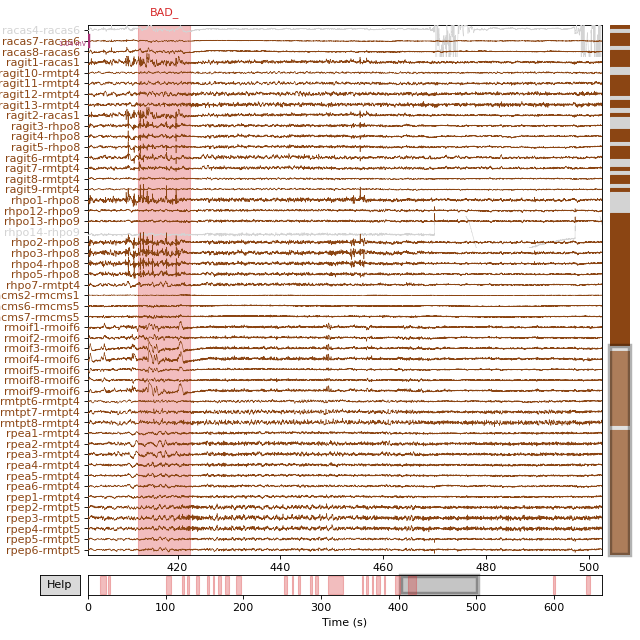

<IPython.core.display.Javascript object>


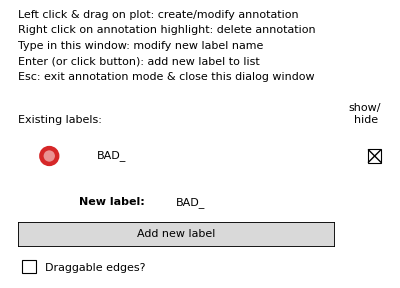

In [60]:
%matplotlib notebook
%matplotlib notebook
# use the epoch code to select only the WM referenced pairs
fig = mne_data_wm_reref.plot(start=2, duration=100, n_channels=50,scalings=mne_data._data.max()/20 ) # plot all channels at once
fig.fake_keypress("a")


In [61]:
mne_data_wm_reref.annotations.onset

array([ 15.41162533,  25.83984944, 100.02304478, 120.72384787,
       127.72787898, 139.24256074, 153.25368128, 160.56900267,
       167.72562062, 177.06432877, 190.59720509, 251.92138865,
       262.73507119, 270.20603772, 285.77055131, 292.77458243,
       309.50078013, 352.37536068, 358.28987584, 365.7995895 ,
       370.93587898, 380.85842056, 394.90522992, 412.33748515,
       598.40068364, 641.83726465])

In [62]:
def join_good_segs(mne_data):
    #creates indices of good epochs after labeling bad times manually, then crops good epochs and joins data 
    
    ### get good times: 
    good_start = list([mne_data_wm_reref.first_time]) #first timepoint in recording (should be 0)
    good_end = []
    
    for annot in mne_data.annotations:
        bad_start = mne_data.time_as_index(annot['onset']) #onset is start time of bad epoch 
        # ^ start time of bad epoch converted to index, then subtract 1 for end of good epoch
        bad_end = mne_data.time_as_index(annot['onset'] + annot['duration']) #onset + duration = end time of bad epoch
        # ^ end time of bad epoch converted to index 
        # must get bad start and end as indices so you can +-1 for good epochs - cannot +-1 using time only indexes

        good_end.append(mne_data.times[bad_start - 1]) #the start time of a bad epoch is the end of a good epoch - 1
        good_start.append(mne_data.times[bad_end+1]) #the end time of a bad epoch is the start of a good epoch +1 index
        #convert to integers before appending - indexing np arrays later is annoying
                          
    good_end.append(mne_data.times[mne_data.last_samp]) #index of last timepoint in recording (should = mne_data.n_times)
    
    ### get good data epochs and concatenate 
    good_segs = []
    for start,end in list(zip(good_start,good_end)):
        good_segs.append(mne_data.copy().crop(tmin=float(start), tmax=float(end),
                include_tmax=True))
    
    return mne.concatenate_raws(good_segs)
    
#derived from: 
    # source: https://mne.discourse.group/t/removing-time-segments-from-raw-object-without-epoching/4169/2
    # source: https://github.com/mne-tools/mne-python/blob/maint/1.5/mne/io/base.py#L681-L742
    
    

In [64]:
mne_data_wm_reref_clean = join_good_segs(mne_data_wm_reref)
mne_data_wm_reref_clean

<RawEDF | MS008_Resting_iEEG.edf, 127 x 272510 (545.0 s), ~264.2 MB, data loaded>

### Save reref data

In [66]:
mne_data_wm_reref_clean.save(f'{save_dir}/{subj_id}_wm_ref_ieeg.fif',overwrite=True)